## TensorFlow/Keras

Мы видели, что для обучения нейросетей нужно:
* Быстро умножать матрицы (тензоры)
* Считать производные для вычисления градиента для метода обратного распространения ошибки

Что позволяют делать нейросетевые фреймворки:
* Оперировать с тензорами, как на CPU, так и на GPU
* Автоматически вычислять производные (они вручную прописаны для всех элементарных функций)

Опционально:
* Конструктор для нейросетей (описание сети как набора слоёв)
* Простые функции для обучения (`fit`, как в Scikit Learn)
* Набор алгоритмов оптимизации
* Набор абстракций для работы с данными

Основные фреймворки:

* Tensorflow 1.0 - первый, получивший широкое распространение (Google). Позволял определять статический computation graph, и затем в явном виде выполнять вычисления
* PyTorch - Facebook
* Keras - надстройка над Tensorflow/PyTorch для унификации (Francois Chollet)
* Tensorflow 2.0 + Keras - динамический вычислительный граф, код получается похожим на обычные вычисления в numpy

Мы рассмотрим Tensorflow 2.0 и Keras. Вам необходимо убедиться, что у вас установлена версия 2.x.x Tensorflow:
```
pip install tensorflow
```
или
```
conda install tensorflow
```
или выполняйте код в [Google Colab](https://colab.research.google.com/)

In [ ]:
import tensorflow as tf
import numpy as np
print(tf.__version__)

## Основные понятия в TensorFlow

**Тензор** - это многомерный массив произвольной размерности. Удобно использовать при обучении нейросетей, например:
* 400x400 - чёрно-белая картинка
* 400x400x3 - цветная картинка
* 16x400x400x3 - minibatch из 16 картинок, используемый для одного шага обучения
* 25x400x400x3 - секунда видео
* 8x25x400x400x3 - minibatch из 8 1-секундных видео

### Простые тензоры

In [ ]:
a = tf.constant([[1,2],[3,4]])
print(a)
a = tf.random.normal(shape=(10,3))
print(a)

С тензорами можно производить обычные вычисления, которые производятся поэлементно (как в numpy). При этом тензоры автоматически дополняются до нужной размерности. Можно извлечь numpy-массив из тензора при помощи `.numpy()`:

In [ ]:
print(a-a[0])
print(tf.exp(a)[0].numpy())

### Переменные

Переменные могут содержать какие-то значения, которые мы затем можем модифицировать с помощью методов `assign` и `assign_add`. 

Например, вот глупый способ посчитать сумму всех строк тензора `a`

In [ ]:
s = tf.Variable(tf.zeros_like(a[0]))
for i in a:
  s.assign_add(i)

print(s)

Умный способ:

In [ ]:
tf.reduce_sum(a,axis=0)

### Вычисляем производные

Для обратного распространения ошибки, нам нужно уметь вычислять градиенты. Это делается с помощью `tf.GradientTape()`:
 * Оборачиваем интересующие нас вычисления в `with tf.GradientTape`
 * Помечаем интересующие нас тензоры вызовом `tape.watch` (переменные отслеживаются автоматически)
 * Проводим вычисления
 * Получаем градиенты через `tape.gradient` 

In [ ]:
a = tf.random.normal(shape=(2, 2))
b = tf.random.normal(shape=(2, 2))

with tf.GradientTape() as tape:
  tape.watch(a)  # Start recording the history of operations applied to `a`
  c = tf.sqrt(tf.square(a) + tf.square(b))  # Do some math using `a`
  # What's the gradient of `c` with respect to `a`?
  dc_da = tape.gradient(c, a)
  print(dc_da)

### Пример 1: Линейная регрессия

Попробуем с помощью полученных знаний решить классическую задачу линейной регрессии. Для этого сгенерируем небольшой синтетический датасет:

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
import random

In [ ]:
np.random.seed(13) # pick the seed for reproducability - change it to explore the effects of random variations

train_x = np.linspace(0, 3, 120)
train_labels = 2 * train_x + 0.9 + np.random.randn(*train_x.shape) * 0.5

plt.scatter(train_x,train_labels)

Линейная регрессия вычисляется как $f_{W,b}(x) = Wx+b$, где $W, b$ - параметры модели, которые необходимо найти. Функция ошибки на наборе данных $\{x_i,y_u\}_{i=1}^N$ может быть определена как среднеевадратичное отклонение
$$
\mathcal{L}(W,b) = {1\over N}\sum_{i=1}^N (f_{W,b}(x_i)-y_i)^2
$$

Опишем модель и функцию ошибки:

In [ ]:
input_dim = 1
output_dim = 1
learning_rate = 0.1

# This is our weight matrix
w = tf.Variable([[100.0]])
# This is our bias vector
b = tf.Variable(tf.zeros(shape=(output_dim,)))

def f(x):
  return tf.matmul(x,w) + b

def compute_loss(labels, predictions):
  return tf.reduce_mean(tf.square(labels - predictions))

Обучать модель будем на сериях примеров - minibatches. Для обучения используем градиентный спуск, подстраивая парметры в соответствии с формулой:
$$
\begin{array}{l}
W^{(n+1)}=W^{(n)}-\eta\frac{\partial\mathcal{L}}{\partial W} \\
b^{(n+1)}=b^{(n)}-\eta\frac{\partial\mathcal{L}}{\partial b} \\
\end{array}
$$

In [ ]:
def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = f(x)
    loss = compute_loss(y, predictions)
    # Note that `tape.gradient` works with a list as well (w, b).
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
  w.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss

Теперь приступаем к обучению: делаем несколько проходов по всему датасету (эпох), разбиваем его на minibatches, и вызываем функцию обучения:

In [ ]:
# Shuffle the data.
indices = np.random.permutation(len(train_x))
features = tf.constant(train_x[indices],dtype=tf.float32)
labels = tf.constant(train_labels[indices],dtype=tf.float32)

In [ ]:
batch_size = 4
for epoch in range(10):
  for i in range(0,len(features),batch_size):
    loss = train_on_batch(tf.reshape(features[i:i+batch_size],(-1,1)),tf.reshape(labels[i:i+batch_size],(-1,1)))
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

In [ ]:
w,b

In [ ]:
plt.scatter(train_x,train_labels)
x = np.array([min(train_x),max(train_x)])
y = w.numpy()[0,0]*x+b.numpy()[0]
plt.plot(x,y)

### Вычислительный граф

Для проведения вычислений Tensorflow строит внутри себя вычислительный граф, который, в т.ч., может вычисляться на GPU. Однако в нашем случае, поскольку мы использовали пользовательские Python-функции, они не включались в вычислительный граф, и при вычислениях на GPU производилась бы передача данных между GPU и CPU и обратно.

Для ускорения высчислений и построения единого статического графа, необходимо отметить все функции соответствующим декоратором:

In [ ]:
@tf.function
def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = f(x)
    loss = compute_loss(y, predictions)
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
  w.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss

### Dataset API

Для работы с данными в Tensorflow присутствует удобное API, которым мы в данном случае можем воспользоваться:

In [ ]:
w.assign([[10.0]])
b.assign([0.0])

# Create a tf.data.Dataset object for easy batched iteration
dataset = tf.data.Dataset.from_tensor_slices((train_x.astype(np.float32), train_labels.astype(np.float32)))
dataset = dataset.shuffle(buffer_size=1024).batch(256)

for epoch in range(10):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(tf.reshape(x,(-1,1)), tf.reshape(y,(-1,1)))
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

### Пример 2: Классификация

Рассмотрим пример двухмерной задачи классификации на 2 класса. Примером такой задачи может быть классификация опухоли на 2 типа - доброкачественная и злокачественная, в зависимости от её размера и возраста.

Сгенерируем тестовые данные случайным образом:


In [ ]:
np.random.seed(0) # pick the seed for reproducability - change it to explore the effects of random variations

n = 100
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0.0,class_sep=1)
X = X.astype(np.float32)
Y = Y.astype(np.int32)

split = [ 70*n//100, (15+70)*n//100 ]
train_x, valid_x, test_x = np.split(X, split)
train_labels, valid_labels, test_labels = np.split(Y, split)

In [ ]:
def plot_dataset(features, labels, W=None, b=None):
    # prepare the plot
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')
    colors = ['r' if l else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    if W is not None:
        min_x = min(features[:,0])
        max_x = max(features[:,1])
        min_y = min(features[:,1])*(1-.1)
        max_y = max(features[:,1])*(1+.1)
        cx = np.array([min_x,max_x],dtype=np.float32)
        cy = (0.5-W[0]*cx-b)/W[1]
        ax.plot(cx,cy,'g')
        ax.set_ylim(min_y,max_y)
    plt.show()

In [ ]:
plot_dataset(train_x, train_labels)

### Обучение простейшего одноуровневого персептрона вручную

Используем возможности tensorflow по вычислению градиента для обучения одноуровневого персептрона.

Для начала, задаём архитектуру сети, в которой будет 2 входа и один выход. Соответственно, матрица весов $W$ будет иметь размерность $2\times1$, а вектор сдвига $b$ -- $1$.

Функция обучение будет такая же, как в прошлом примере, но функция ошибки будет представлять собой логистическую функцию ошибки. Для этого нам нужно получить на выходе сети значение **вероятности** класса 1, т.е. необходимо привести выход сети $z$ к диапазону [0,1] с помощью передаточной функции `sigmoid`: $p=\sigma(z)$.
Далее, если для примера с номером класса $y_i\in\{0,1\}$ был получен выход сети $p_i$, то ошибка вычисляется как $\mathcal{L_i}=-(y_i\log p_i + (1-y_i)log(1-p_i))$. 

В Tensorflow оба эти этапа (применение сигмоиды и взятие логистической функции ошибки) делается одним вызовом `sigmoid_cross_entropy_with_logits`. Поскольку мы делаем обучение по минибатчам, то необходимо усреднить ошибку по всем компонентам минибатча с помощью `reduce_mean`. 

In [ ]:
W = tf.Variable(tf.random.normal(shape=(2,1)))
b = tf.Variable(tf.zeros(shape=(1,),dtype=tf.float32))

learning_rate = 0.1

@tf.function
def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    z = tf.matmul(x, W) + b
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=z))
    dloss_dw, dloss_db = tape.gradient(loss, [W, b])
  W.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss

Далее, разбиваем входные данные на минибатчи по 16 элементов, и по-очереди проводим обучение, подстраивая веса $W$ и $b$

In [ ]:
# Create a tf.data.Dataset object for easy batched iteration
dataset = tf.data.Dataset.from_tensor_slices((train_x, train_labels.astype(np.float32)))
dataset = dataset.batch(16)

for epoch in range(15):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(tf.reshape(x,(-1,2)), tf.reshape(y,(-1,1)))
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Для демонстрации того, как сработало обучение, построим граничную прямую $W\times x + b = 0.5$

In [ ]:
plot_dataset(train_x,train_labels,W.numpy(),b.numpy())

Посмотрим на результат классификации на тестовом датасете:

In [ ]:
pred = tf.matmul(valid_x,W)+b
fig,ax = plt.subplots(1,2)
ax[0].scatter(valid_x[:,0],valid_x[:,1],c=pred[:,0]>0.5)
ax[1].scatter(valid_x[:,0],valid_x[:,1],c=valid_labels)

Посчитаем точность:

In [ ]:
tf.reduce_mean(tf.cast(((pred[:,0]>0.5)==valid_labels),tf.float32))

### Используем оптимизаторы TensorFlow

Tensorflow достаточно плотно интегрирован с библиотекой Keras, которая содержит в себе множество полезного. Например, мы можем использовать оптимизаторы, реализующие немного другие алгоритмы обучения, чем градиентный спуск.

Изменение весов для градиентного спуска имеет вид:
$$\begin{align}
\Delta W^{(i)} &= \eta\frac{\partial \mathcal{L}}{\partial W}\\
\Delta b^{(i)} &= \eta\frac{\partial \mathcal{L}}{\partial b}\\
\end{align}
$$
В результате на каждом шаге направление градиента может существенно меняться из-за того, что мы рассматриваем новый минибатч. Именно поэтому градиентный спуск называется *стохастическим*.

Чтобы сгладить такие изменения, мы можем на каждом шаге сохранять некоторые значения градиентов с прошлого шага, т.е.

$$\begin{align}
\Delta W^{(i)} &= \beta\Delta W^{(i-1)} + (1-\beta)\eta\frac{\partial \mathcal{L}}{\partial W}\\
\Delta b^{(i)} &= \beta\Delta b^{(i)} + (1-\beta)\eta\frac{\partial \mathcal{L}}{\partial b}\\
\end{align}
$$
Такой алгоритм называется **Momentum** Gradient Descent. Сущесвуют и другие алгоритмы оптимизации, такие как **AdaGrad**, **Adam** и др.

Также попробуем выводить точность на всех этапах обучения.

In [26]:
import tensorflow.keras

optimizer = tf.keras.optimizers.Adam(0.01)

learning_rate = 0.05

W = tf.Variable(tf.random.normal(shape=(2,1)))
b = tf.Variable(tf.zeros(shape=(1,),dtype=tf.float32))

@tf.function
def train_on_batch(x, y):
  vars = [W, b]
  with tf.GradientTape() as tape:
    z = tf.sigmoid(tf.matmul(x, W) + b)
    loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(z,y))
    correct_prediction = tf.equal(tf.round(y), tf.round(z))
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    grads = tape.gradient(loss, vars)
    optimizer.apply_gradients(zip(grads,vars))
  return loss,acc

for epoch in range(40):
  for step, (x, y) in enumerate(dataset):
    loss,acc = train_on_batch(tf.reshape(x,(-1,2)), tf.reshape(y,(-1,1)))
  print('Epoch %d: last batch loss = %.4f, acc = %.4f' % (epoch, float(loss),acc))

Epoch 0: last batch loss = 9.0650, acc = 0.1667
Epoch 1: last batch loss = 9.0169, acc = 0.1667
Epoch 2: last batch loss = 8.9621, acc = 0.1667
Epoch 3: last batch loss = 8.9025, acc = 0.3333
Epoch 4: last batch loss = 8.8384, acc = 0.3333
Epoch 5: last batch loss = 8.7696, acc = 0.3333
Epoch 6: last batch loss = 8.6959, acc = 0.3333
Epoch 7: last batch loss = 8.6170, acc = 0.5000
Epoch 8: last batch loss = 8.5325, acc = 0.5000
Epoch 9: last batch loss = 8.4422, acc = 0.3333
Epoch 10: last batch loss = 8.3461, acc = 0.3333
Epoch 11: last batch loss = 8.2439, acc = 0.3333
Epoch 12: last batch loss = 8.1359, acc = 0.3333
Epoch 13: last batch loss = 8.0223, acc = 0.3333
Epoch 14: last batch loss = 7.9037, acc = 0.3333
Epoch 15: last batch loss = 7.7805, acc = 0.3333
Epoch 16: last batch loss = 7.6537, acc = 0.3333
Epoch 17: last batch loss = 7.5241, acc = 0.3333
Epoch 18: last batch loss = 7.3929, acc = 0.5000
Epoch 19: last batch loss = 7.2611, acc = 0.5000
Epoch 20: last batch loss = 7.

**Задание 1**: Постройте графики ошибок на обучающей и тестовой выборке в процессе обучения

**Задание 2**: Попробуйте решить задачу классификации на датасете MNIST с помощью этого кода. Подсказка: используйте `softmax_crossentropy_with_logits` или `sparse_softmax_cross_entropy_with_logits` в качестве функции ошибки. При этом в первом случае на выход сети необходимо подавать целевые значения в формате *one hot encoding*, а во втором - в виде целочисленного номера класса.

## Keras
### Deep Learning for Humans

* Раньше работал поверх Tensorflow, CNTK или Theano, сейчас включен в состав Tensorflow
* Оперирует нейросетями на уровне слоёв
* Включает упрощённый "обучатель", средства работы с типовыми данными (картинками, ...)
* Много готовых примеров
* Functional API vs. Sequential API

Keras даёт более высокоуровневое API для реализации нейросетей, позволяя определять нейросети как комбинации слоёв и оперировать понятиями "модель", "слой", "алгоритм обучения".

Книжка от создателя Keras: [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)

In [27]:
inputs = tf.keras.Input(shape=(2,))

z = tf.keras.layers.Dense(1,kernel_initializer='glorot_uniform',activation='sigmoid')(inputs)

model = tf.keras.models.Model(inputs,z)

train_x_norm = train_x-np.min(train_x) / (np.max(train_x)-np.min(train_x))

model.compile(tf.keras.optimizers.Adam(0.1),'binary_crossentropy',['accuracy'])
model.summary()
h = model.fit(train_x_norm,train_labels,batch_size=8,epochs=15)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
9/9 [==============================] - 1s 4ms/step - loss: 0.8767 - accuracy: 0.3000
Epoch 2/15
9/9 [==============================] - 0s 3ms/step - loss: 0.5285 - accuracy: 0.7286
Epoch 3/15
9/9 [==============================] - 0s 3ms/step - loss: 0.4032 - accuracy: 0.9143
Epoch 4/15
9/9 [==============================] - 0s 4ms/step - loss: 0.3484 - accuracy: 0.9000
Epoch 5/15
9/9 [==============================] - 0s 3ms/step - loss: 0.3256 - accuracy: 0.8857
Epoch 6/15
9/9 [==============================] -

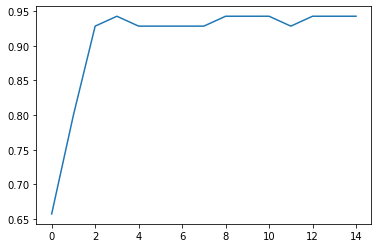

In [39]:
plt.plot(h.history['accuracy'])

Выше мы использовали **функциональный** способ задания модели, когда мы сначала описываем входную переменную, затем - происходящие с ней преобразования, и потом определяем объект `Model`.

Мы можем также задавать модель как последовательности слоёв с помощью `Sequential`:

In [37]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(5,activation='sigmoid',input_shape=(2,)))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

test_x_norm = test_x-np.min(train_x) / (np.max(train_x)-np.min(train_x))
# это не ошибка, мы нормируем тестовые данные так же, как нормировали обучающие!
# (поэтому min и max считаем для обучающих данных)

model.compile(optimizer=tf.keras.optimizers.Adam(0.1),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
h = model.fit(train_x_norm,train_labels,validation_data=(test_x_norm,test_labels),batch_size=8,epochs=15)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 5)                 15        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
9/9 [==============================] - 2s 49ms/step - loss: 0.6823 - accuracy: 0.6571 - val_loss: 0.5901 - val_accuracy: 0.7333
Epoch 2/15
9/9 [==============================] - 0s 12ms/step - loss: 0.5311 - accuracy: 0.8000 - val_loss: 0.3238 - val_accuracy: 1.0000
Epoch 3/15
9/9 [==============================] - 0s 13ms/step - loss: 0.3713 - accuracy: 0.9286 - val_loss: 0.1648 - val_accuracy: 1.0000
Epoch 4/15
9/9 [==============================] - 0s 12ms/step - loss: 0.3069 - accuracy: 0.9429 - val_

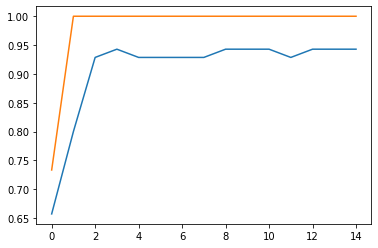

In [40]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])

## Функции ошибки при классификации

При использовании Keras для классификации важно правильно указать функцию ошибки и передаточную функцию на последнем слое. Основные правила:
* Если у сети один выход, то передаточная функция - сигмоида, если несколько - softmax
* Если на ожидаемый выход подается в виде one-hot-encoding, то функция ошибки - cross entropy loss (categorical cross-entropy), если номер класса - sparse categorical cross-entropy, для бинарной классификации с одним выходом - binary cross-entropy (она же log loss)

В целом бинарную классификацию можно рассматривать как частный случай мультиклассовой, подавая на выход one hot encoded вектор.

| Классификация | Формат входных данных | Передат.функция | Функция ошибки |
|---------------|-----------------------|-----------------|----------|
| Бинарная      | Вероятность 1-го класса | sigmoid | binary crossentropy |
| Бинарная      | One-hot encoding (2 выхода) | softmax | categorical crossentropy |
| Мультикласс |  One-hot encoding | softmax | categorical crossentropy |
| Мультикласс | Номер класса | softmax | sparse categorical crossentropy

## Выводы

* Tensorflow позволяет более гибко определять структуру графа вычислений, описывать свои функции и конфигурации.
* Есть более удобные средства для работы с данными (`td.Data`), со слоями (`tf.layers`)
* Для массового использования нейросетей Google рекомендует **Keras**, который позволяет собирать нейросети как конструктор
* При этом возможно реализовать свой слой для Keras, и потом использовать его в своих моделях.
* Для типовых задач имеет смысл использовать Keras
* Также стоит посмотреть на PyTorch, это "восходящая звезда"

Хороший Notebook про Keras и Tensorflow 2.0 от создателя Keras - [тут](https://t.co/k694J95PI8)

**Задание 3**: 
Используйте Keras для обучения классификатора на сети MNIST. При этом:
* Обратите внимание, что в keras заложены типовые датасеты, включая MNIST. Для обращения к нему достаточно пары строчек кода (см, например, [тут](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist))
* Попробуйте несколько конфигураций сети с несколькими полносвязными слоями, передаточными функциями, и разным количеством нейронов

Какой точности вам удалось достичь?
